In [8]:
# Cell 1: Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, RandomRotation, ColorJitter
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Configuration
IMG_SIZE = 224
BATCH_SIZE = 8          # Reduce due to multi-view (3x images per sample)
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: mps


In [9]:
# Cell 2: Multi-View Conversion
def load_point_cloud(file_path):
    """Load point cloud from various formats"""
    try:
        suffix = file_path.suffix.lower()
        if suffix == '.txt' or suffix == '.xyz':
            data = np.loadtxt(file_path)
        elif suffix == '.pts':
            with open(file_path, 'r') as f:
                lines = f.readlines()
                data = []
                for line in lines:
                    parts = line.strip().split()
                    if len(parts) >= 3:
                        try:
                            data.append([float(parts[0]), float(parts[1]), float(parts[2])])
                        except:
                            continue
                data = np.array(data)
        else:
            return None
        return data[:, :3] if data.shape[1] >= 3 else None
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def normalize_points(points):
    """Normalize to unit cube [-0.5, 0.5]"""
    points = (points - points.min(axis=0)) / (points.max(axis=0) - points.min(axis=0) + 1e-6)
    return points - 0.5

def render_view(points, axis1, axis2, img_size=224):
    """Render projection onto two axes"""
    x = points[:, axis1]
    y = points[:, axis2]
    z = points[:, 3 - axis1 - axis2]  # third axis for color

    # Normalize to [0, 1]
    x = ((x - x.min()) / (x.max() - x.min() + 1e-6)) * (img_size - 1)
    y = ((y - y.min()) / (y.max() - y.min() + 1e-6)) * (img_size - 1)
    z = (z - z.min()) / (z.max() - z.min() + 1e-6)

    img = np.zeros((img_size, img_size), dtype=np.float32)
    counts = np.zeros((img_size, img_size), dtype=np.float32)

    for i in range(len(points)):
        xi, yi = int(x[i]), int(y[i])
        if 0 <= xi < img_size and 0 <= yi < img_size:
            img[yi, xi] = max(img[yi, xi], z[i])  # height as intensity
            counts[yi, xi] += 1

    # Normalize by density
    img = np.clip(img * (counts > 0), 0, 1)
    return Image.fromarray((img * 255).astype(np.uint8), mode='L')

def point_cloud_to_multiview_images(points, img_size=224):
    """Generate 3 orthogonal views"""
    if points is None or len(points) < 10:
        return [Image.new('L', (img_size, img_size), 0)] * 3

    points = normalize_points(points)

    # XY (top), XZ (front), YZ (side)
    xy = render_view(points, 0, 1, img_size)  # top-down
    xz = render_view(points, 0, 2, img_size)  # front
    yz = render_view(points, 1, 2, img_size)  # side

    return [xy, xz, yz]

In [10]:
# Cell 3: Load Data
def load_tree_data(data_path):
    data_path = Path(data_path)
    file_paths = []
    labels = []

    if not data_path.exists():
        raise FileNotFoundError(f"{data_path} not found!")

    for species_dir in data_path.iterdir():
        if species_dir.is_dir():
            species_name = species_dir.name
            files = list(species_dir.glob("*.txt")) + list(species_dir.glob("*.xyz")) + list(species_dir.glob("*.pts"))
            print(f" {species_name}: {len(files)} files")
            file_paths.extend(files)
            labels.extend([species_name] * len(files))

    print(f" Total: {len(file_paths)} files across {len(set(labels))} species")
    return file_paths, labels

# Load
data_path = Path("../test")
all_file_paths, all_labels = load_tree_data(data_path)

if len(all_file_paths) == 0:
    raise ValueError("No data found!")

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(all_labels)
num_classes = len(label_encoder.classes_)

# Train/val/test split
from sklearn.model_selection import train_test_split
train_paths, test_paths, train_labels, test_labels = train_test_split(
    all_file_paths, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)

print(f" Split: Train={len(train_paths)}, Val={len(val_paths)}, Test={len(test_paths)}")

 Oak: 4 files
 Douglas Fir: 36 files
 Spruce: 31 files
 Pine: 5 files
 Ash: 7 files
 Red Oak: 19 files
 Beech: 32 files
 Total: 134 files across 7 species
 Split: Train=85, Val=22, Test=27


In [11]:
class TreeMultiViewDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None, img_size=224):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        self.img_size = img_size

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        points = load_point_cloud(self.file_paths[idx])
        images = point_cloud_to_multiview_images(points, self.img_size) 
        if self.transform:
            images = [self.transform(img) for img in images]  
        image = torch.stack(images, dim=0)  # Shape: (3, 1, H, W)

        label = self.labels[idx]
        return image, label
    
# Transforms
train_transform = Compose([
    Resize((IMG_SIZE, IMG_SIZE)),
    RandomRotation(15),
    ColorJitter(brightness=0.2, contrast=0.2),
    ToTensor(),
    Normalize(mean=[0.5], std=[0.5])
])

test_transform = Compose([
    Resize((IMG_SIZE, IMG_SIZE)),
    ToTensor(),
    Normalize(mean=[0.5], std=[0.5])
])
# Datasets
train_dataset = TreeMultiViewDataset(train_paths, train_labels, train_transform)
val_dataset = TreeMultiViewDataset(val_paths, val_labels, test_transform)
test_dataset = TreeMultiViewDataset(test_paths, test_labels, test_transform)

# Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f" Loaders ready. Sample shape: {next(iter(train_loader))[0].shape}")

 Loaders ready. Sample shape: torch.Size([8, 3, 1, 224, 224])


In [ ]:
# Cell 5: Improved CNN
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        # second conv keeps out_channels
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return self.relu(out)

class MultiViewCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Per-view images are single-channel (grayscale). Use in_channels=1.
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2, 1),
            BasicBlock(64, 64),
            BasicBlock(64, 64),
            BasicBlock(64, 128, 2),
            BasicBlock(128, 128),
            BasicBlock(128, 256, 2),
            BasicBlock(256, 256),
            nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x):
        # Accept either:
        # - (B, views, C, H, W)  (expected)
        # - (B, views, H, W)     -> assume missing channel dim, treat as single-channel
        # - (B, C, H, W)         -> single-view batch, treat as 1 view
        if x.dim() == 5:
            b, views, c, h, w = x.shape
        elif x.dim() == 4:
            b, d1, h, w = x.shape
            # if second dim looks like views (3) -> (B, views, H, W)
            if d1 > 1 and d1 <= 10:
                # add channel dim: (B, views, 1, H, W)
                x = x.unsqueeze(2)
                b, views, c, h, w = x.shape
            else:
                # treat as (B, C, H, W) -> make it (B, 1, C, H, W)
                x = x.unsqueeze(1)
                b, views, c, h, w = x.shape
        else:
            raise ValueError(f"Unexpected input tensor shape {x.shape}")

        x = x.view(-1, c, h, w)         # (B*views, C, H, W)
        x = self.features(x)            # (B*views, 256, 1, 1)
        x = x.view(b, views, -1)        # (B, views, 256)
        x = x.mean(dim=1)               # average over views -> (B, 256)
        return self.classifier(x)
# Model
model = MultiViewCNN(num_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(
    [1.0 / Counter(train_labels)[i] for i in range(num_classes)]
).to(DEVICE))  # Weighted loss for imbalance
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

print(f" Model: {sum(p.numel() for p in model.parameters()):,} params")

 Model: 2,778,311 params


In [6]:

def train_model(model, train_loader, val_loader, epochs):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_acc = 0.0

    for epoch in range(epochs):
        model.train()
        loss_meter = 0.0
        correct = 0
        total = 0

        for views, labels in train_loader:
            views, labels = views.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(views)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            loss_meter += loss.item()
            _, pred = outputs.max(1)
            total += labels.size(0)
            correct += pred.eq(labels).sum().item()

        train_loss = loss_meter / len(train_loader)
        train_acc = 100. * correct / total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for views, labels in val_loader:
                views, labels = views.to(DEVICE), labels.to(DEVICE)
                outputs = model(views)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, pred = outputs.max(1)
                val_total += labels.size(0)
                val_correct += pred.eq(labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100. * val_correct / val_total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_multiview_model.pth")

        scheduler.step()

        print(f"Epoch {epoch+1:2d}/{epochs} | "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%")

    model.load_state_dict(torch.load("best_multiview_model.pth"))
    return model, best_acc, train_losses, val_losses, train_accs, val_accs

# Train
start_time = time.time()
trained_model, best_val_acc, train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader, NUM_EPOCHS
)
print(f" Training done in {time.time() - start_time:.2f}s")

Epoch  1/50 | Train Loss: 2.2177 Acc: 17.65% | Val Loss: 2.2375 Acc: 9.09%
Epoch  2/50 | Train Loss: 1.6265 Acc: 37.65% | Val Loss: 4.6595 Acc: 4.55%
Epoch  3/50 | Train Loss: 1.6569 Acc: 36.47% | Val Loss: 2.9627 Acc: 9.09%
Epoch  4/50 | Train Loss: 1.5582 Acc: 30.59% | Val Loss: 2.8941 Acc: 13.64%
Epoch  5/50 | Train Loss: 1.4469 Acc: 32.94% | Val Loss: 1.6680 Acc: 40.91%
Epoch  6/50 | Train Loss: 1.3708 Acc: 37.65% | Val Loss: 1.7985 Acc: 18.18%
Epoch  7/50 | Train Loss: 1.3641 Acc: 47.06% | Val Loss: 2.0833 Acc: 18.18%
Epoch  8/50 | Train Loss: 1.2993 Acc: 40.00% | Val Loss: 2.0672 Acc: 40.91%
Epoch  9/50 | Train Loss: 1.3554 Acc: 37.65% | Val Loss: 1.7541 Acc: 31.82%
Epoch 10/50 | Train Loss: 1.4821 Acc: 28.24% | Val Loss: 2.1889 Acc: 54.55%
Epoch 11/50 | Train Loss: 1.3298 Acc: 45.88% | Val Loss: 2.2715 Acc: 4.55%
Epoch 12/50 | Train Loss: 1.1839 Acc: 44.71% | Val Loss: 2.2537 Acc: 13.64%
Epoch 13/50 | Train Loss: 1.2394 Acc: 55.29% | Val Loss: 1.7684 Acc: 22.73%
Epoch 14/50 | Tr


 Final Test Accuracy: 66.67%
Best Val Accuracy: 72.73%

 Classification Report:
              precision    recall  f1-score   support

         Ash       0.50      1.00      0.67         1
       Beech       1.00      1.00      1.00         7
 Douglas Fir       0.50      0.57      0.53         7
         Oak       0.00      0.00      0.00         1
        Pine       1.00      1.00      1.00         1
     Red Oak       1.00      0.50      0.67         4
      Spruce       0.43      0.50      0.46         6

    accuracy                           0.67        27
   macro avg       0.63      0.65      0.62        27
weighted avg       0.69      0.67      0.66        27



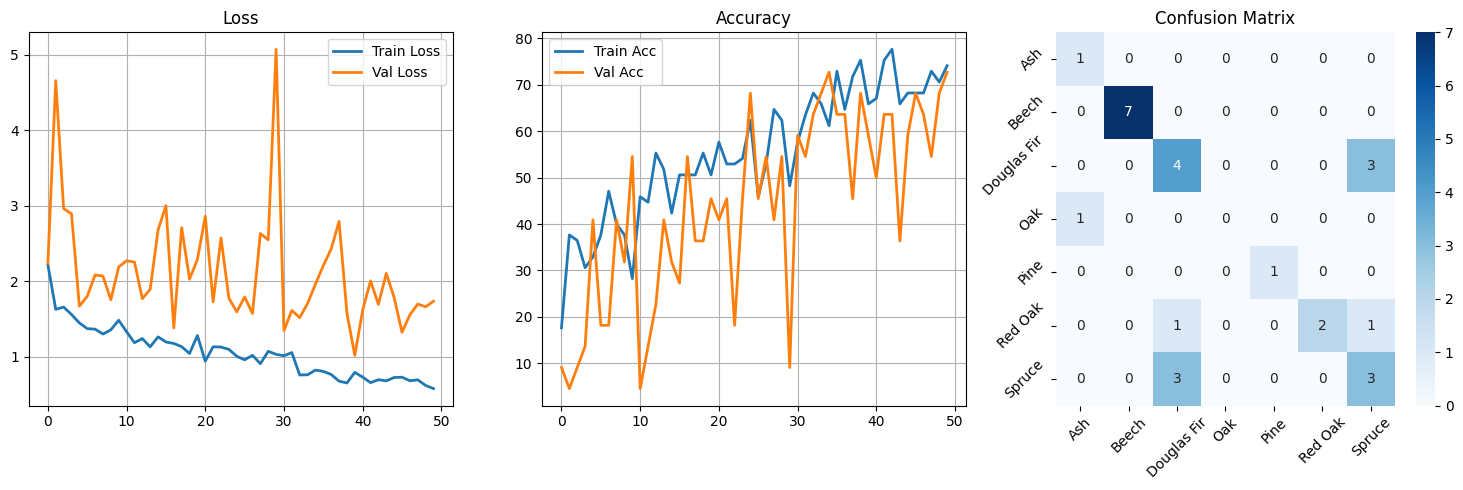

In [7]:
# Cell 7: Evaluate
def evaluate(model, loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for views, labels in loader:
            views, labels = views.to(DEVICE), labels.to(DEVICE)
            outputs = model(views)
            _, pred = outputs.max(1)
            preds.append(pred.cpu())
            targets.append(labels.cpu())
    return torch.cat(preds).numpy(), torch.cat(targets).numpy()

y_pred, y_true = evaluate(trained_model, test_loader)
test_acc = accuracy_score(y_true, y_pred) * 100

print(f"\n Final Test Accuracy: {test_acc:.2f}%")
print(f"Best Val Accuracy: {best_val_acc:.2f}%")

# Report
names = label_encoder.classes_
print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=names))

# Plots
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label="Train Loss", lw=2)
plt.plot(val_losses, label="Val Loss", lw=2)
plt.legend(); plt.title("Loss"); plt.grid()

plt.subplot(1, 3, 2)
plt.plot(train_accs, label="Train Acc", lw=2)
plt.plot(val_accs, label="Val Acc", lw=2)
plt.legend(); plt.title("Accuracy"); plt.grid()

plt.subplot(1, 3, 3)
cm = confusion_matrix(y_true, y_pred, labels=range(len(names)))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=names, yticklabels=names)
plt.title("Confusion Matrix"); plt.xticks(rotation=45); plt.yticks(rotation=45)
plt.tight_layout(); plt.show()